In [1]:
import sys
%load_ext autoreload
%autoreload 2

sys.path.append("../libs/")
from data_prep import *



# Load and prepare data

In [2]:
X,y=load_data()


##Tests 
def test1(value):
    if value>=35:
        return 1
    else:
        return 0
def test2(value):
    if value <30 or value>60:
        return 1
    else:
        return 0
###

##Replace with binary for age and make ycolumn: 0 or 1
X=replace_values_with_binary(X,"Attribute9",["A91","A93","A94"])# transform Attribute9 it into gender column
y=replace_values_with_binary(y,y.columns[0],[2])# transform y to col with 0/1 values
X=apply_function_to_column(df=X,column_name="Attribute13",test_function=test1, new_name="Age_group")

num_features=["Attribute2", "Attribute5", "Attribute8", "Attribute11", "Attribute13", "Attribute16", "Attribute18"]
cat_features=[col_name for col_name in X.columns if col_name not in num_features]
X = pd.get_dummies(X, columns = cat_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=123)

X_val,X_test,y_val,y_test=train_test_split(X_test,y_test, test_size=0.5, random_state=123) ##this make 0.15 for both val and test

## Save sensitive attributes

gender_train=X_train["Attribute9_1"]
age_train=X_train["Age_group_1"]

gender_test=X_test["Attribute9_1"]
age_test=X_test["Age_group_1"]

gender_val=X_val["Attribute9_1"]
age_val=X_val["Age_group_1"]






#Drop columns for without attribute and redundant ones

X_train_with_A=X_train.copy() #X with sensitive_attributes
X_train_with_A.drop("Age_group_1" , axis=1, inplace=True)
X_train_without_A=X_train.drop(["Age_group_1","Attribute9_1" ], axis=1)

X_test_with_A=X_test.copy() #X with sensitive_attributes
X_test_with_A.drop("Age_group_1" , axis=1, inplace=True)
X_test_without_A=X_test.drop(["Age_group_1","Attribute9_1" ], axis=1)

X_val_with_A=X_test.copy() #X with sensitive_attributes
X_val_with_A.drop("Age_group_1" , axis=1, inplace=True)
X_val_without_A=X_test.drop(["Age_group_1","Attribute9_1" ], axis=1)















Data loaded successfully


Brief analysis

Index(['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13',
       'Attribute16', 'Attribute18', 'Attribute1_A12', 'Attribute1_A13',
       'Attribute1_A14', 'Attribute3_A31', 'Attribute3_A32', 'Attribute3_A33',
       'Attribute3_A34', 'Attribute4_A41', 'Attribute4_A410', 'Attribute4_A42',
       'Attribute4_A43', 'Attribute4_A44', 'Attribute4_A45', 'Attribute4_A46',
       'Attribute4_A48', 'Attribute4_A49', 'Attribute6_A62', 'Attribute6_A63',
       'Attribute6_A64', 'Attribute6_A65', 'Attribute7_A72', 'Attribute7_A73',
       'Attribute7_A74', 'Attribute7_A75', 'Attribute9_1', 'Attribute10_A102',
       'Attribute10_A103', 'Attribute12_A122', 'Attribute12_A123',
       'Attribute12_A124', 'Attribute14_A142', 'Attribute14_A143',
       'Attribute15_A152', 'Attribute15_A153', 'Attribute17_A172',
       'Attribute17_A173', 'Attribute17_A174', 'Attribute19_A192',
       'Attribute20_A202', 'Age_group_1'],
      dtype='object')
     class
0        0
1        1
2      

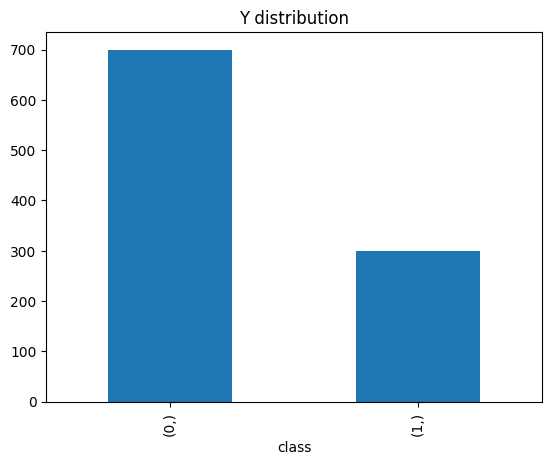

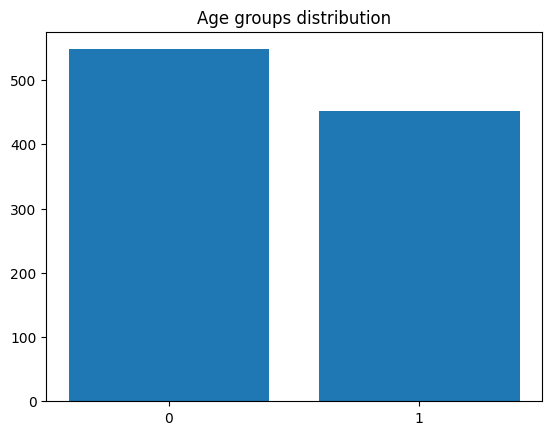

In [3]:
print(X.columns)
y.value_counts().plot.bar()
print(y)
plt.title("Y distribution")
plt.show()





# Create an array to represent the index (0 and 1)
index = np.array([0, 1])

# Create a list of the numbers
values = [X.shape[0]- X["Age_group_1"].sum(),X["Age_group_1"].sum()]

# Create the bar plot
plt.bar(index, values)

# Set the x-tick labels for the index
plt.xticks(index, ['0', '1'])

plt.title("Age groups distribution")
plt.show()


# Prediction 

In [4]:
#########MODEL 



param_grid_rf = {
    'n_estimators': [10,50, 100],
    'max_depth': [10, 20,30,50],
    'min_samples_leaf': [2, 4,8]
}


#param_grid_svc = {
    #'C': [0.1, 1, 10],
    #'kernel': ['linear']
#}

param_grid_knn = {
    'n_neighbors': [3,5, 10, 20]
}


model_rf=RandomForestClassifier()
#model_svc = SVC()
model_knn = KNeighborsClassifier()


best_rf = find_best_model(model_rf, param_grid_rf, X_train_without_A, y_train.values.ravel())[0]
#best_svc = find_best_model(model_svc, param_grid_svc, X_train_without_A, y_train.values.ravel())[0]
best_knn = find_best_model(model_knn, param_grid_knn, X_train_without_A, y_train.values.ravel())[0]




# Define the parameter grids for each model


#param_grid_svc = {
    #'C': [0.1, 1],
    #'kernel': ['linear']
#}

param_grid_knn = {
    'n_neighbors': [3,5, 10,20]
}











Accuracy for best grid search RandomForestClassifier() is : 0.7442857142857143
Accuracy for best grid search KNeighborsClassifier() is : 0.7142857142857142


In [7]:
from fairlearn.metrics import equalized_odds_difference as eq_odds_dif


print(f" train gender eq op diff : {eq_op_dif(y_train,best_rf.predict(X_train_without_A), sensitive_attribute=gender_train)}")
print(f"train age eq op diff : {eq_op_dif(y_train,best_rf.predict(X_train_without_A), sensitive_attribute=age_train)}")

print(f"val gender eq op diff : {eq_op_dif(y_val,best_rf.predict(X_val_without_A), sensitive_attribute=gender_val)}")
print(f"val age eq op diff : {eq_op_dif(y_val,best_rf.predict(X_val_without_A), sensitive_attribute=age_val)}")

print(f"train gender eq odds diff : {eq_odds_dif(y_train,best_rf.predict(X_train_without_A), sensitive_features=gender_train)}")
print(f"train age eq odds diff : {eq_odds_dif(y_train,best_rf.predict(X_train_without_A), sensitive_features=age_train)}")

print(f"val gender eq odds diff : {eq_odds_dif(y_val,best_rf.predict(X_val_without_A), sensitive_features=gender_val)}")
print(f"val age eq odds diff : {eq_odds_dif(y_val,best_rf.predict(X_val_without_A), sensitive_features=age_val)}")

 train gender eq op diff : 0.09931359931359929
train age eq op diff : 0.28070750081886664
val gender eq op diff : 0.11428571428571428
val age eq op diff : 0.0617816091954023
train gender eq odds diff : 0.09931359931359929
train age eq odds diff : 0.28070750081886664
val gender eq odds diff : 0.11428571428571428
val age eq odds diff : 0.0617816091954023
